In [1]:
import astropy
from astropy.io import fits 
from astropy.time import Time
from astropy.visualization import time_support
from astropy.timeseries import LombScargle
from astropy.convolution import Box1DKernel
from astropy.convolution import convolve
import matplotlib.pyplot as plt
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import numpy as np
import numpy.ma as ma
import os
import pandas as pd
import scipy.signal as sig
from astropy.stats import sigma_clip
import warnings

In [2]:
from functools import partial

import matplotlib as mpl
from scipy import signal, stats
from scipy.ndimage import center_of_mass

# install moonbow first. in repo root:
# pip install -e . --no-deps
from moonbow.fit import Fit

rng = np.random.default_rng()

In [3]:
def dataClean(filename,distance_pc,eff_width): 
    
    """ This function removes nan values and corrects time values for TESS 20 second cadence data. 
        Also corrects TESS flux to energy in ergs."""
    
    #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly") as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]

    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    
    #Create Dataframe of cleaned data
    time = np.array(times)
    flux = np.array(flux)
    err = np.array(error)
   

    #Convert energy to ergs
    dist_cm = distance_pc * 3.086e+18
    ergs = []
    ergs_err = []
    
    for i in flux: 
        fluence = i * eff_width
        energy = (4 * np.pi * (dist_cm**2) * fluence)
        ergs.append(energy*1.95829e-9) #AB system zero point
        
    for i in err:
        fluence_err = i*eff_width
        energy_err = (4 * np.pi * (dist_cm**2) * fluence_err)
        ergs_err.append(energy_err*1.95829e-9) #AB system zero point
        
    energy = np.asarray(ergs)
    error = np.asarray(ergs_err)

    
    #Return cleaned data
    return pd.DataFrame({
                        'Time': time,
                        'Energy': energy,
                        'Energy Error': error,
                        'Flux': flux,
                        'Flux Error': err
    })

In [4]:
#Using only until large flare function is completed, need more stars to get a better idea for a good
#model for stellar quiescence generation

def generate_Qcurve(clean_dataframe):
    """ This function takes cleaned data to create a dataframe of the estimated quiescent light curve"""

    q_time = clean_dataframe['Time'] # time associated w/ quiescent flux
    
    #Set and index variables
    fluxes = clean_dataframe['Energy']
    times = clean_dataframe['Time']
    F_err = clean_dataframe['Energy Error'] 

    #Smooth
    smooth_1 = sig.savgol_filter(fluxes,1400,3)
    q_flux = sig.savgol_filter(smooth_1,2000,3)
    
    #Create/return dataframe
    
    return pd.DataFrame({
                'Time': q_time,
                'Quiescent Energy':q_flux
    })


In [5]:
def find_ix_ranges(ix, buffer=False):
    """ Finds indexes in the range.
    
        From MC GALEX function defs"""
    
    foo, bar = [], []
    for n, i in enumerate(ix):
        if len(bar) == 0 or bar[-1] == i-1:
            bar += [i]
        else:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
            bar = [i]
        if n == len(ix)-1:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
    return foo

In [6]:
def get_inff(curve,distance_pc, clipsigma=3, quiet=True, band='NUV',
             binsize=20.):
    """ Calculates the Instantaneous Non-Flare Flux values.
    
        From MC GALEX function defs"""
    
    sclip = sigma_clip(np.array(curve['Energy']), sigma_lower=clipsigma, sigma_upper=clipsigma)
    inff = np.median(sclip)
    inff_err = np.sqrt(inff*len(sclip)*binsize)/(len(sclip)*binsize)
    if inff and not quiet:
        print('Quiescent at {m} AB mag.'.format(m=gt.counts2mag(inff, band)))
    inff_ = ((inff*(3.898e-5))*(4*np.pi*((distance_pc*3.086e+18)**2)))*1.95829e-9
    inff_er = ((inff_err*(3.898e-5))*(4*np.pi*((distance_pc*3.086e+18)**2)))*1.95829e-9
    return inff, inff_er

In [7]:
def find_flare_ranges(curve,q_curve,sig,dist,quiescence=None):
    """This function will run through the data to find 
    flares and ranges of flares. This function will return
    a table of flares ranges. 
    
    Adapted from MC GALEX function defs.
    Stage: complete"""
    
    tranges = [[min(curve['Time']), max(curve['Time'])]] 
    if not quiescence:
        q, q_err = get_inff(curve,dist)
    else:
        q, q_err = quiescence
    flare_ranges = []
    for trange in tranges:
        ix = np.where(((np.array(curve['Energy'].values)-(sig*np.array(curve['Energy Error'].values)) >= q_curve['Quiescent Energy'])))[0]
        flareFlux = ix
        if not len(ix):
            continue
        flux_ix = []
        
        for ix_range in find_ix_ranges(ix):
            # go backwards
            consec = 0 
            err = curve.iloc[ix_range[0]]['Energy Error'] 
            
            #while flux - err > quiescence, find 2 consecutive points within quiescent curve
            while (curve.iloc[ix_range[0]]['Energy']-err >= q_curve.iloc[ix_range[0]]['Quiescent Energy']) and ix_range[0] > 0 or (consec < 1 and ix_range[0] >0):
                err = curve.iloc[ix_range[0]]['Energy Error']

                if curve.iloc[ix_range[0]]['Energy']- err < q_curve.iloc[ix_range[0]]['Quiescent Energy']:
                    consec +=1
                else: 
                    consec = 0
                if (curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 1000: 
                    break               
                ix_range = [ix_range[0] - 1] + ix_range
                
                # go forwards
            consec = 0 
            err = curve.iloc[ix_range[-1]]['Energy Error']
            while (curve.iloc[ix_range[-1]]['Energy']-err >= q_curve.iloc[ix_range[-1]]['Quiescent Energy']) and ix_range[-1] != len(curve)-1 or (consec <1 and ix_range[:-1]!= len(curve)-1):
                err = curve.iloc[ix_range[-1]]['Energy Error']
                if curve.iloc[ix_range[-1]]['Energy']-err < q_curve.iloc[ix_range[-1]]['Quiescent Energy']:
                    consec += 1
                else: 
                    consec = 0
                if curve.iloc[ix_range[0]]['Time']-curve.iloc[ix_range[-1]]['Time'] > 1000: 
                    break
                ix_range = ix_range + [ix_range[-1] + 1]
                
            flux_ix += ix_range
        ix = np.unique(flux_ix)
        flare_ranges += find_ix_ranges(list(np.array(ix).flatten()))
    return(flare_ranges,flareFlux)


In [8]:
def refine_flare_ranges(curve,q_curve, sig=3., flare_ranges=None):
    """ Identify the start and stop indexes of a flare event after
    refining the INFF by masking out the initial flare detection indexes. 
    From MC GALEX function defs."""
    time_support()
    if not flare_ranges:
        flare_ranges, _ = find_flare_ranges(curve, q_curve, sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    quiescience_mask = [False if i in flare_ix else True for i in
                        np.arange(len(curve['Time']))]
    quiescence = q_curve
    quiescence_err = (np.sqrt(curve['Energy'][quiescience_mask].sum())/curve['Energy'].sum())
    flare_ranges, flare_3sigs = find_flare_ranges(curve,q_curve,
                                                  quiescence=(quiescence,
                                                              quiescence_err),
                                                  sig=sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    not_flare_ix = list(set([x for x in range(len(curve['Time']))]) - set(flare_ix))
      
    return flare_ranges, flare_ix

In [9]:
def qpp_find(flaring_frame,ranges_ix,energy_ix):
    
    ranges = []
    for i,v in enumerate(ranges_ix):
        t = flaring_frame['Time'][v]
        f = flaring_frame['Flux'][v]
        ranges.append([i,t,f])

        #Select Large Flares

    large_flares = []
    for i,v in enumerate(ranges_ix):
        if len(v)>=45:                    #~15 minute minimum                    
            large_flares.append((v))
        else:
            continue

#Match Data to Large Flares

    large_flare_data = []
    for i,v in enumerate(large_flares):
        data = flaring_frame['Energy'][large_flares[i]]
        large_flare_data.append(data)
    
    norm_flares=[] #normalize flare values
    for i in range(len(large_flare_data)):
        mx = max(large_flare_data[i])
        norm_flares.append(large_flare_data[i]/mx)
    
    times=[]
    for i in range(len(large_flares)):
        t = flaring_frame['Time'][large_flare_data[i].index]
        times.append(t)
        
    lg_flare_data=[]
    lg_flare_time=[]
    lg_flare_det=[]
    lg_flare_params = []
    flare_fits = []

    for i in range(len(large_flares)):
        model = aflare2
        x = flaring_frame['Time'][large_flares[i]]
        y = norm_flares[i]
        data = pd.DataFrame({'time': x, 'energy': y})
    
        rise = x[0:np.argmax(y)].values
        fwhm = (max(rise)-min(rise))*2
    
        fitter = Fit(
        underlying_function=model,
        dimensionality=1,
        data=data,
        dependent_variable='energy')
    
        fitter.make_vector(independent_variables=['time'])
        fitter.fit(guess=np.array((max(rise),fwhm,1,
                              1.00000, 1.94053, -0.175084, -2.3769, -1.12498,
                              0.689008, -1.600536, 0.302963, -0.278318))) 
        if fitter.det > 0.70:
            lg_flare_time.append(x)
            lg_flare_data.append(y)
            lg_flare_det.append(fitter.det)
            fit_params, covariance_matrix = fitter.curve_fit
            lg_flare_params.append((fit_params))
            fit = fitter.fitted_curve 
            flare_fits.append((fit))
    return lg_flare_data, lg_flare_time, lg_flare_det, lg_flare_params, flare_fits

In [10]:
def fit_residuals(lg_flare_data,flare_fits):
    residuals = []
    for i in range(len(lg_flare_data)):
        res_i = lg_flare_data[i]-flare_fits[i]
        residuals.append((res_i))

    kernel = Box1DKernel(8)
    res_fits = []
    for i in range(len(residuals)):
        res_fit = sig.savgol_filter(residuals[i],21,3)
        fit2 = convolve(res_fit,kernel,boundary='extend')
        res_fits.append(fit2)
    
    return(residuals, res_fits)


#to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(res_fits)):
#    ax.flat[i].plot(range(len(residuals[i])),residuals[i],c='grey')
#    ax.flat[i].plot(range(len(res_fits[i])),res_fits[i],c='black')

In [11]:
def aflare2(t, tpeak, fwhm, ampl,
            c0,c1,c2,c3,c4,
            d0,d1,d2,d3):
#    t : 1-d array
#        The time array to evaluate the flare over
#    tpeak : float
#        The time of the flare peak
#    fwhm : float
#        The "Full Width at Half Maximum", timescale of the flare
#   ampl : float
#        The amplitude of the flare
#    Returns
#    flare : 1-d array
#        The flux of the flare model evaluated at each time
    #_fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fr = [c0,c1,c2,c3,c4]
    #_fd = [0.689008, -1.60053, 0.302963, -0.278318]
    _fd = [d0,d1,d2,d3]
    
    t = np.array(t)
    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

### Af Psc Analysis

In [12]:
#rawdata = '/Users/katborski/Documents/GitHub/AFPSC/TESS/tess2021232031932-s0042-0000000250081915-0213-a_fast-lc.fits'
#flaring_frame = dataClean(rawdata,35,3.898e-5) #35=dist in pc, 3.898e-5=eff width for Af Psc
#q_frame = generate_Qcurve(flaring_frame)

In [13]:
#ranges_ix,energy_ix = find_flare_ranges(flaring_frame, q_frame, 3,35, quiescence=None)

/Users/katborski/opt/anaconda3/envs/moonbow/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [14]:
#qpps = qpp_find(flaring_frame, ranges_ix, energy_ix)

In [15]:
#res_fit = fit_residuals(qpps[0],qpps[4])

In [16]:
###to view/plot davenport fit: 

#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(lg_flare_data)):    
#    ax.flat[i].plot(lg_flare_time[i],lg_flare_data[i])
#    ax.flat[i].plot(lg_flare_time[i],fits_[i],c='black')
#    ax.flat[i].set_title(lg_flare_det[i])
#    plt.setp(ax, xticks=[]) 

In [17]:
###to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(res_fits)):
#    ax.flat[i].plot(range(len(residuals[i])),residuals[i],c='grey')
#    ax.flat[i].plot(range(len(res_fits[i])),res_fits[i],c='black')

### Test Analysis w/ EV Lac

In [41]:
#test_rawdata = '/Users/katborski/Documents/GitHub/QPPs/moonbow-main/tess2022244194134-s0056-0000000154101678-0243-a_fast-lc.fits'
#test_flaring_frame = dataClean(test_rawdata,5.05,3.898e-5) #5.05=dist in pc to EV Lac, 3.898e-5=eff width for TESS
#test_q_frame = generate_Qcurve(test_flaring_frame)


In [42]:
#test_ranges_ix,test_energy_ix = find_flare_ranges(test_flaring_frame,test_q_frame,4,5.05,quiescence=None)

In [43]:
#test_qpps = qpp_find(test_flaring_frame, test_ranges_ix, test_energy_ix)

In [21]:
#test_res_fit = fit_residuals(test_qpps[0],test_qpps[4])

In [22]:
###to view/plot davenport fit: 

#fig,ax = plt.subplots((len(test_qpps[0])))
#for i in range(len(test_qpps[0])):    
#    ax.flat[i].plot(test_qpps[1][i],test_qpps[0][i])
#    ax.flat[i].plot(test_qpps[1][i],test_qpps[4][i],c='black')
#    ax.flat[i].set_title(test_qpps[2][i])
#    plt.setp(ax, xticks=[]) 
#plt.show()

In [23]:
###to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(test_res_fit[0])))
#for i in range(len(test_res_fit[0])):
#    ax.flat[i].plot(range(len(test_res_fit[0][i])),test_res_fit[0][i],c='grey')
#    ax.flat[i].plot(range(len(test_res_fit[1][i])),test_res_fit[1][i],c='black')
#plt.show()

In [24]:
#ALL WORKING, uncomment singular '#' lines to run.

In [25]:
### CROSSMATCH DATA W/ GAIA ###
warnings.filterwarnings('ignore')

In [26]:
dataset = pd.read_csv('/Users/katborski/Documents/GitHub/QPPs/G03228_S039.csv')

In [27]:
skypos = []
for i in range(len(dataset)):
    ra = dataset['RA'][i]
    dec = dataset['Dec'][i]
    skypos.append((ra,dec))

In [28]:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

In [29]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

In [30]:
# define the search box
width = u.Quantity(0.05, u.deg)
height = u.Quantity(0.05, u.deg)

rs = []
for i in range(len(skypos)):
    query_success=0
    while query_success==0:
        #print(ra[i],dec[i])
        try:
            r = Gaia.query_object_async(coordinate=coord.SkyCoord(ra=skypos[i][0], dec=skypos[i][1], unit=(u.degree, u.degree),
                                                          frame='icrs'), width=width, height=height)
            rs.append(r)
            query_success=1
        except TimeoutError:
            pass

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


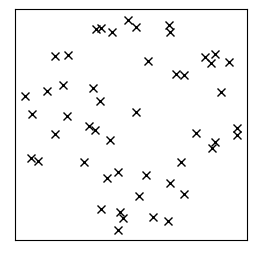

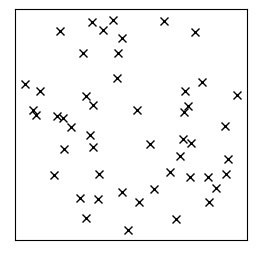

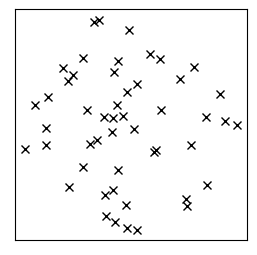

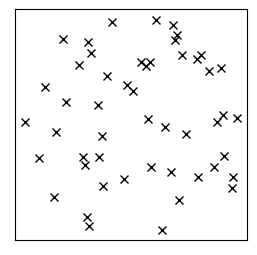

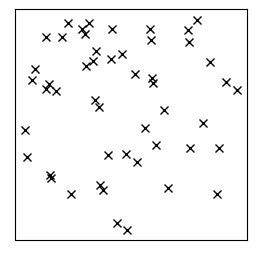

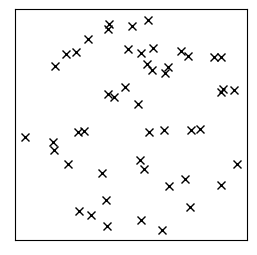

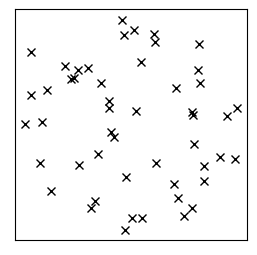

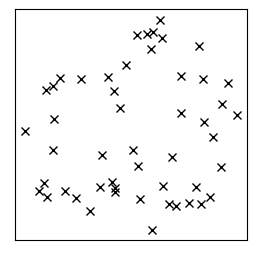

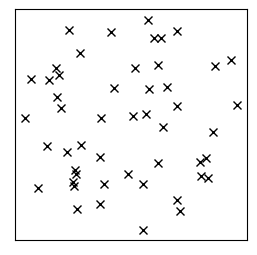

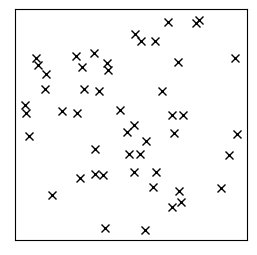

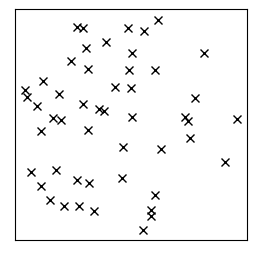

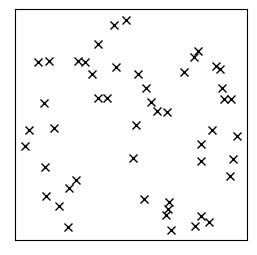

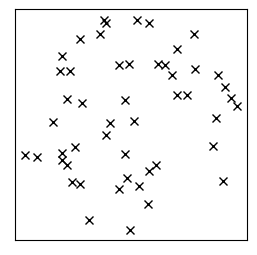

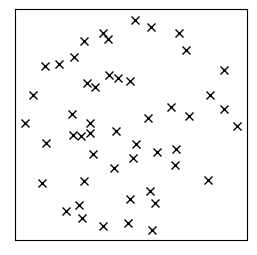

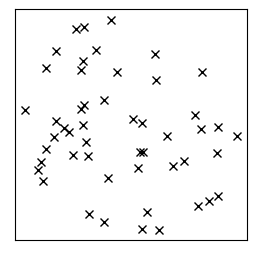

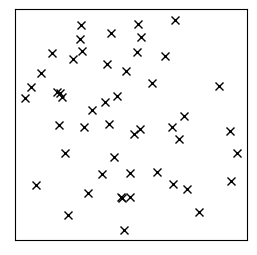

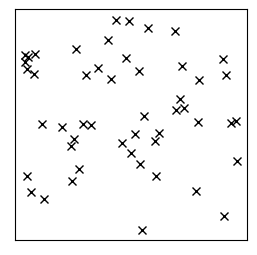

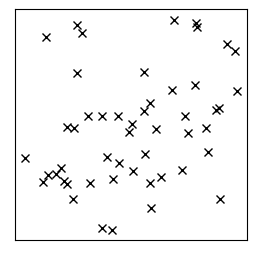

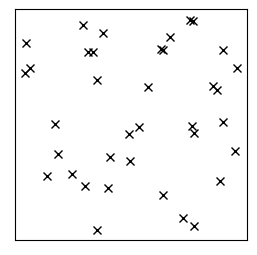

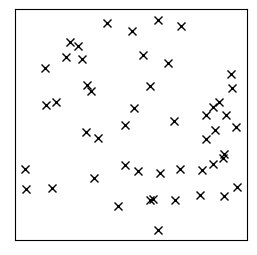

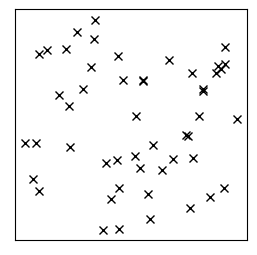

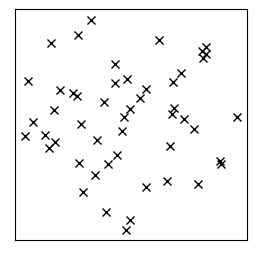

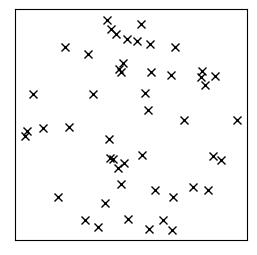

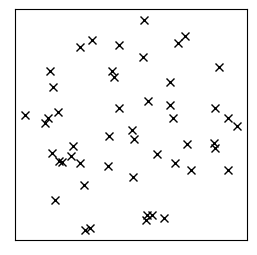

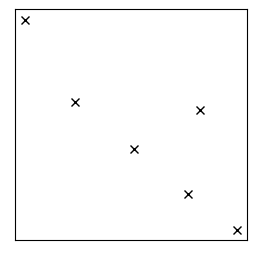

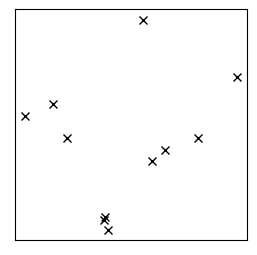

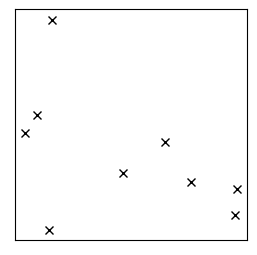

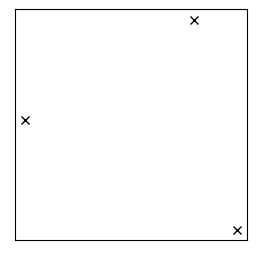

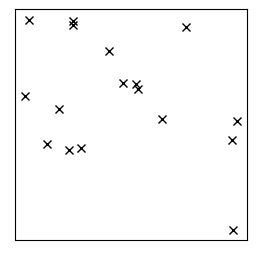

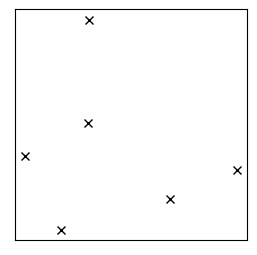

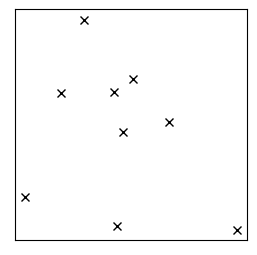

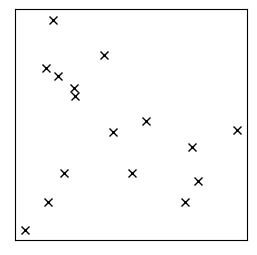

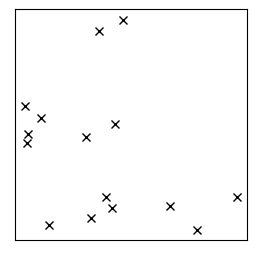

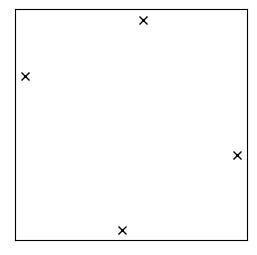

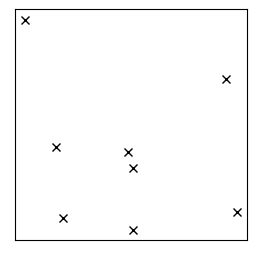

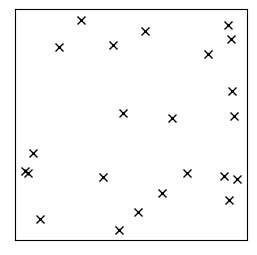

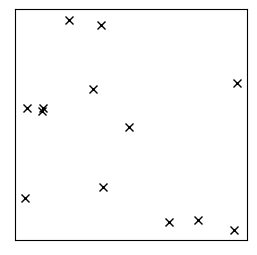

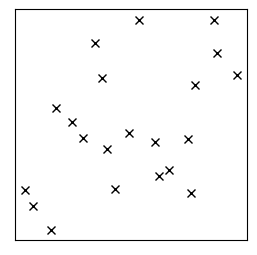

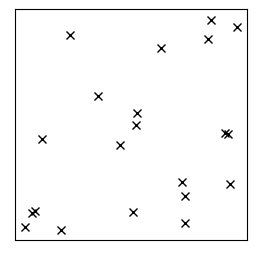

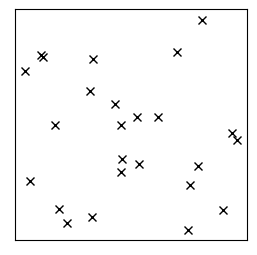

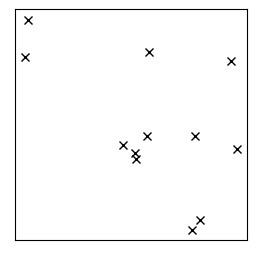

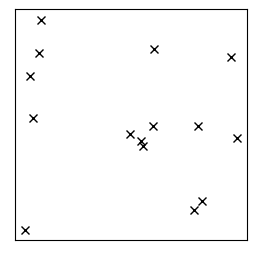

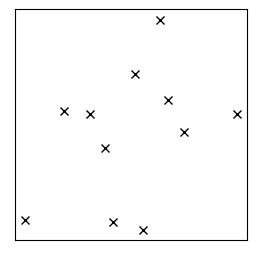

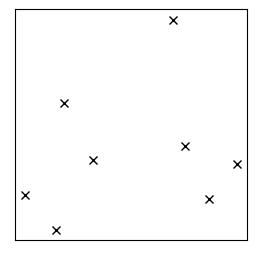

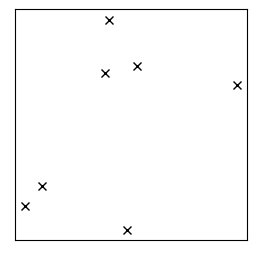

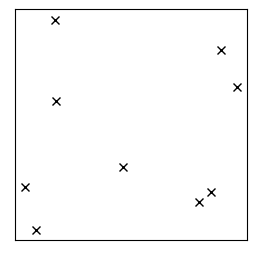

In [31]:
for i in range(len(rs)):
    plt.figure(figsize=(3,3))
    plt.xticks([]);plt.yticks([]);
    ra_gaia,dec_gaia = np.array(rs[i]['ra']),np.array(rs[i]['dec'])
    plt.plot(ra_gaia,dec_gaia,'kx')
    ix_finite = np.where(np.isfinite(ra_gaia) & np.isfinite(dec_gaia))
    d = angularSeparation(skypos[i][0],skypos[i][1],ra_gaia[ix_finite],dec_gaia[ix_finite])    
    try:
        ix_match = np.argmin(d)
    except ValueError:
        print(f"No matching Gaia source for {i}")
        raise


In [32]:
print('GAIA MATCH OFFSET')
for i in range(len(skypos)):    
    ix = ix_finite[0][ix_match]
    gaia_match_offset=angularSeparation(skypos[i][0],skypos[i][1],rs[i][ix]['ra'],rs[i][ix]['dec'])*60*60
    print(f"{gaia_match_offset[0]} as")  

GAIA MATCH OFFSET
1.7562154072115128 as
2.279899037132109 as
2.3317520894081554 as
3.565031796140075 as
3.97830457022191 as
1.6541144207707743 as
2.107414734522161 as
4.495175007118396 as
1.5449165906098086 as
2.469343827463157 as
1.7708883005988034 as
1.7384604919850062 as
1.6706479399670282 as
1.7535218029961883 as
0.7609593223187203 as
6.786268604098917 as
1.8446208113574105 as
2.5653087091254814 as
2.408637391422862 as
2.010295797674756 as
5.550801209466304 as
1.8812003939482504 as
9.54915300612377 as
2.8995671471823883 as
6.60358128037951 as
3.902055504427569 as
4.1845451555799995 as
1.7433935146221717 as
1.2911409505014966 as
1.1348177073456727 as
3.8032547396183403 as
2.665257869748266 as
5.710229749431574 as
1.5428451661687776 as
3.5483974689350326 as
1.8337522446591514 as
2.1607815529199823 as
2.597186946190024 as
1.8998278380312186 as
2.6670718983863755 as
0.8413875507578151 as
0.8094653969539398 as
0.7555770803028411 as
0.4081901507197295 as
2.194213038035021 as
2.1851408764

In [33]:
print('GAIA ID & DISTANCES')
for i in range(len(rs)):
    gaia_dr3_source_id=rs[i][ix]['source_id']
    par,par_err = rs[i][ix]['parallax'],rs[i][ix]['parallax_error']
    gaia_distance=1000/par
    print(gaia_dr3_source_id,'@',f'{gaia_distance} parsecs')
    

GAIA ID & DISTANCES
5942630107855861888 @ 19.28567647915926 parsecs
5934097210481810432 @ 13.490298747284413 parsecs
5942777304971775360 @ 1930.592672490794 parsecs
5943550124208359552 @ 15.758980945153473 parsecs
5955305209181045120 @ 3603.161821613204 parsecs
5924187617032756736 @ 12.77758403449611 parsecs
5950304355395342848 @ -2410.637464216813 parsecs
5951824116677596800 @ 3555.6056996156535 parsecs
5951535219996858624 @ 19.629419902935943 parsecs
5946986063684477056 @ 9.679787481027113 parsecs
5925209583053212800 @ 15.979907974339552 parsecs
4055584308787727488 @ 14.137580128878465 parsecs
4055585060376248832 @ 14.148429334882723 parsecs
4040839372724022144 @ 1778.9721406825615 parsecs
5970189504223192960 @ 15.72767180453325 parsecs
6021430250773348736 @ 8.512696256657831 parsecs
5798502241016325120 @ 19.12806613607902 parsecs
5819260638284592000 @ -5408.261249142059 parsecs
5805810454276180864 @ 3341.4327953044503 parsecs
5815970800722940800 @ 14.586739971320739 parsecs
59107109

In [34]:
gpoe=[]
for i in range(len(rs)):
    gaia_parallax_over_err = rs[i][ix]['parallax_over_error']
    gpoe.append(gaia_parallax_over_err)

In [35]:
gpoe

[1977.8201,
 2495.9136,
 1.9680592,
 3349.0398,
 0.50764114,
 4003.607,
 -0.7174528,
 2.8076754,
 2222.082,
 4792.019,
 2062.3997,
 608.15594,
 3774.105,
 1.1726369,
 3481.5535,
 4039.4219,
 2718.475,
 -0.33918494,
 25.50149,
 3422.7837,
 1678.6511,
 2001.2745,
 3654.1372,
 masked,
 2.9284801,
 4568.0137,
 5100.341,
 3074.5596,
 masked,
 4967.3394,
 3967.9534,
 4197.603,
 3966.884,
 2938.9656,
 23.929295,
 6086.885,
 7869.5,
 987.45245,
 6055.3726,
 3301.084,
 5424.387,
 4307.722,
 5696.9893,
 2777.9495,
 2637.4336,
 3.8607273]

In [39]:
 
### LEGAL VOTable fields defined in:
### https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

Simbad.add_votable_fields("otype","parallax","sp")
r = Simbad.query_region(coord.SkyCoord(ra,dec,
                        unit=(u.deg, u.deg)),#, frame='icrs'),
                        radius=35/60/60*u.deg)

In [40]:
r['SP_TYPE']

M3e
